## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
#fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
universe = pd.read_csv('all_20170405_20230327.csv')
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d')
universe.set_index(['date'],inplace=True)
#print(fundamental_df.shape, universe.shape)

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [3]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,pe,pb,total_share,free_share,total_mv,circ_mv,name,...,alpha_winlos,alpha_skew2sentiment,alpha_fundamental,alpha_turnover,alpha_atr,alpha_rsi,sector_1,sector_2,sector_3,sector_4
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13,300204.SZ,20180213,0.7855,21.5629,2.5671,47781.2254,17840.6481,567163.1455,553816.3976,舒泰神,...,0.000003,-0.002982,0.085884,1.129305,0.375110,32.467,False,False,False,True
2018-02-14,300204.SZ,20180214,0.6961,20.6365,2.4568,47781.2254,17840.6481,542794.7205,530021.4218,舒泰神,...,0.000003,-0.002982,0.089739,1.256124,0.510566,24.141,False,False,False,True
2018-02-22,300204.SZ,20180222,0.3041,20.8726,2.4849,47781.2254,17840.6481,549006.2798,536086.8078,舒泰神,...,0.000003,-0.002982,0.088724,2.474635,0.374342,29.659,False,False,False,True
2018-02-23,300204.SZ,20180223,0.2725,21.0180,2.5022,47781.2254,17840.6481,552828.7779,539819.3530,舒泰神,...,0.000003,-0.002982,0.960378,2.684564,0.317421,33.245,False,False,False,True
2018-02-26,300204.SZ,20180226,0.3631,21.4176,2.5498,47781.2254,17840.6481,563340.6475,550083.8524,舒泰神,...,0.000003,-0.002982,0.086466,2.159361,0.284368,42.857,False,False,False,True


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [4]:
quantile_jud = all_factors['log-ret'].quantile([0.35,0.65,1.])
quantile_jud

0.35   -0.007556
0.65    0.006855
1.00    0.182592
Name: log-ret, dtype: float64

In [5]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>0.006, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [6]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)
#all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2)

all_factors = all_factors.dropna()
all_factors['target'] = all_factors['target'].astype(np.int16)

In [7]:
all_factors['target'].unique()

array([ 1,  0, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

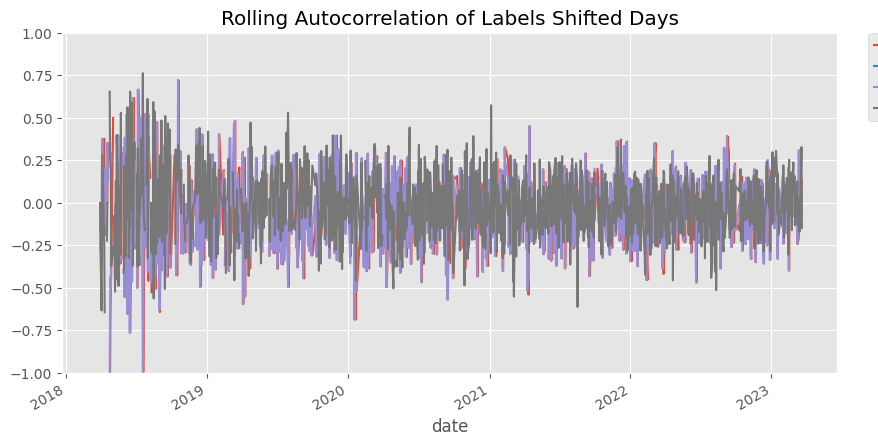

In [8]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220301]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [9]:
# 'total_mv' not add
features = [ 
                'amount','total_mv','total_share','volume',
                'pb','pe','cci_6','supertrend',
                'alpha_skew2sentiment', 'alpha_winlos', 
                'alpha_rsi', 'alpha_atr','alpha_turnover', 
                'alpha_supertrend',  'alpha_cci', 'alpha_fundamental'
          ]

target_label = 'target'
print(all_factors.shape)

(53353, 66)


### nomalize all data by each day

In [10]:
#for feature in features:
def normalize_data(df):
    df[features] = df[features]/abs(df[features]).max(axis=0)
    return df

all_factors[features] = all_factors.groupby('trade_date')[features].apply(normalize_data)
features = features + sector_columns

In [11]:
#all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
#all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
#all_factors.shape
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
all_factors.head()

,,trade_date,turnover_rate,pe,pb,total_share,free_share,total_mv,circ_mv,name,industry,...,sector_1,sector_2,sector_3,sector_4,return_2q,target,target_1,target_2,target_3,target_4
date,ts_code,,,,,,,,,,,,,,,,,,,,,
2018-02-14,300204.SZ,20180214,0.6961,1.0,1.0,1.0,17840.6481,1.0,530021.4218,舒泰神,生物制药,...,False,False,False,True,-1,1,1.0,1.0,1.0,1.0
2018-02-22,300204.SZ,20180222,0.3041,1.0,1.0,1.0,17840.6481,1.0,536086.8078,舒泰神,生物制药,...,False,False,False,True,1,1,1.0,1.0,1.0,0.0
2018-02-23,300204.SZ,20180223,0.2725,1.0,1.0,1.0,17840.6481,1.0,539819.3530,舒泰神,生物制药,...,False,False,False,True,1,1,1.0,1.0,0.0,1.0
2018-02-26,300204.SZ,20180226,0.3631,1.0,1.0,1.0,17840.6481,1.0,550083.8524,舒泰神,生物制药,...,False,False,False,True,1,0,1.0,0.0,1.0,-1.0
2018-02-27,300204.SZ,20180227,0.5981,1.0,1.0,1.0,17840.6481,1.0,563614.3288,舒泰神,生物制药,...,False,False,False,True,1,1,0.0,1.0,-1.0,0.0


In [12]:
tmp = all_factors.dropna().copy()
print(tmp.shape)
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.65, 0.15, 0.2)

X_test.head()

(53073, 66)


amount  total_mv  total_share    volume        pb  \
date       ts_code                                                          
2022-03-18 603368.SH  0.078797  0.363703     0.247566  0.057813  0.133100   
           002872.SZ  0.002545  0.095790     0.217259  0.006203  0.080612   
           300485.SZ  0.288839  0.475698     0.329077  0.217507  0.312576   
           600211.SH  0.052058  0.578670     0.169392  0.016315  0.420762   
           603590.SH  0.005164  0.262136     0.109313  0.002327  0.174704   

                            pe     cci_6  supertrend  alpha_skew2sentiment  \
date       ts_code                                                           
2022-03-18 603368.SH  0.008889  0.037720    0.298571              0.014947   
           002872.SZ  1.000000  0.231825    0.087954             -0.454835   
           300485.SZ  0.053421  0.426900    0.211888             -0.138685   
           600211.SH  0.048178  0.230087    0.663258             -0.029645   
           603590.SH  0.024869  0.125683    0.470018              0.003956   

                      alpha_winlos  alpha_rsi  alpha_atr  alpha_turnover  \
date       ts_code                                                         
2022-03-18 603368.SH     -0.154032   0.623806   0.231064        0.120327   
           002872.SZ     -0.099391   0.627742   0.036316        0.580940   
           300485.SZ      0.215522   0.892349   0.342279        0.023899   
           600211.SH      0.013677   0.633967   0.476048        0.279405   
           603590.SH      0.026829   0.608229   0.190160        0.997291   

                      alpha_supertrend  alpha_cci  alpha_fundamental  \
date       ts_code                                                     
2022-03-18 603368.SH         -0.282130   0.038710          -0.663245   
           002872.SZ         -0.144794   0.515195           0.006187   
           300485.SZ          0.553918   0.011361           0.233369   
           600211.SH         -0.097909   0.049915          -0.020999   
           603590.SH         -0.126389   0.233778           0.262544   

                      sector_1  sector_2  sector_3  sector_4  
date       ts_code                                            
2022-03-18 603368.SH     False      True     False     False  
           002872.SZ      True     False     False     False  
           300485.SZ     False     False     False      True  
           600211.SH     False     False      True     False  
           603590.SH      True     False     False     False

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [29]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 2500,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [50, 100, 200, 250]

### Pick Important Features by Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 4/4 [00:15<00:00,  3.87s/Model]


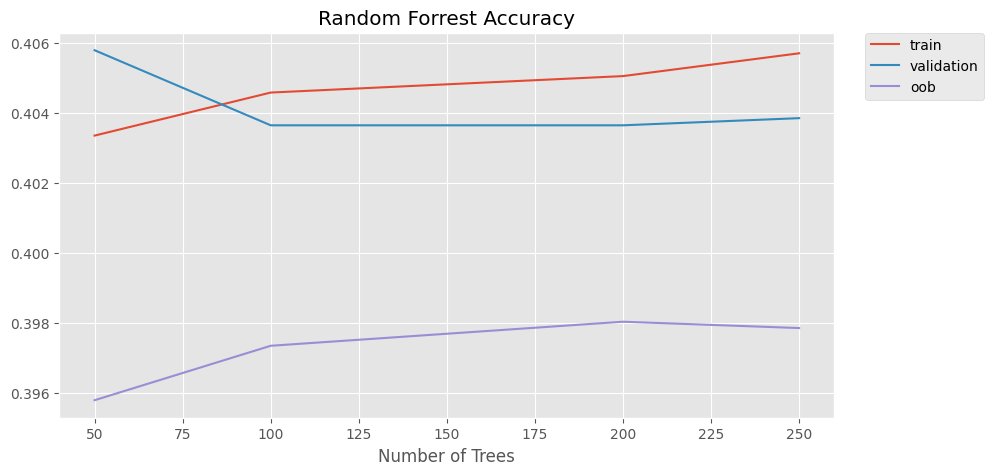

Features Ranked by Average Importance:

      Feature                  Importance
 1. amount               (0.20675797628035497)
 2. alpha_turnover       (0.16534685401202592)
 3. alpha_supertrend     (0.1096112028685308)
 4. alpha_cci            (0.09446976061857526)
 5. volume               (0.09033155598450465)
 6. alpha_atr            (0.0873916848776355)
 7. pe                   (0.08484771660326582)
 8. pb                   (0.03298751693378194)
 9. alpha_winlos         (0.023554612425388533)
10. cci_6                (0.020325338474566933)
11. supertrend           (0.017700146496109095)
12. total_share          (0.015880665114210067)
13. alpha_rsi            (0.013206985560806819)
14. total_mv             (0.012991597845290614)
15. alpha_fundamental    (0.009340062625668888)
16. sector_4             (0.007237741142397772)
17. alpha_skew2sentiment (0.006593647322638448)
18. sector_2             (0.0007157301531771762)
19. sector_1             (0.0006892673250489866)
20. sector_3  

In [31]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [53]:
n_days = 5
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 1000,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [100, 150, 180, 200]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 4/4 [00:20<00:00,  5.24s/Model]


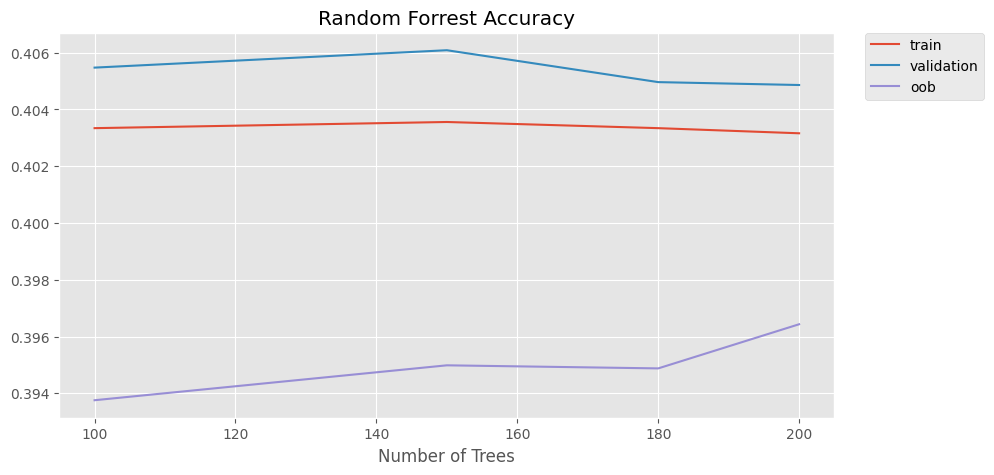

In [54]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.4059850883464406
Precision score:  0.4059850883464406
Recall score:  0.4059850883464406
F1 score:  0.4059850883464406


In [45]:
factor_names = [
                'volume', 'cci_6','supertrend',
                'alpha_skew2sentiment', 'alpha_winlos', 
                'alpha_rsi', 'alpha_atr','alpha_turnover', 
                'alpha_cci', 'alpha_fundamental'
           ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

ts_code,000028.SZ,000153.SZ,000411.SZ,000705.SZ,000756.SZ,000915.SZ,000952.SZ,002082.SZ,002365.SZ,002393.SZ,...,688117.SH,688163.SH,688189.SH,688317.SH,688553.SH,688566.SH,688656.SH,688658.SH,688687.SH,688799.SH
date,,,,,,,,,,,,,,,,,,,,,
2018-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Evalueate alpha factor

In [46]:
import alphalens as al

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

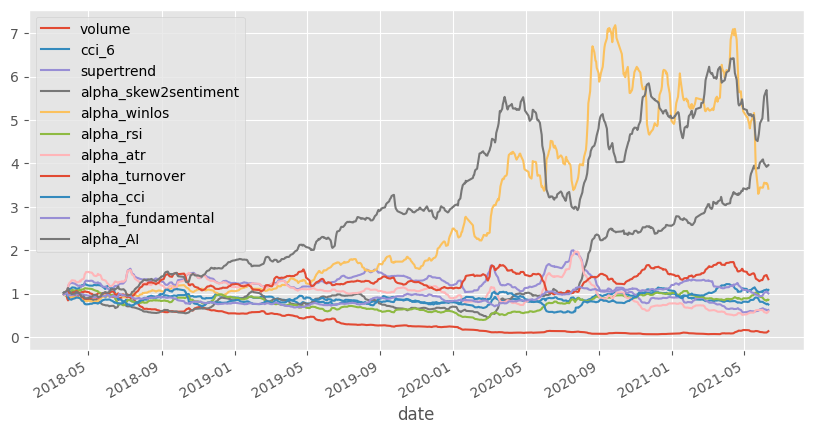

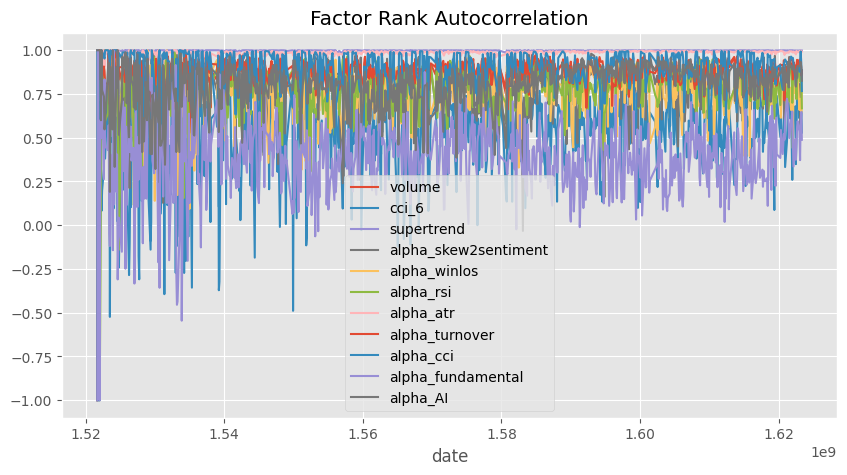

In [47]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

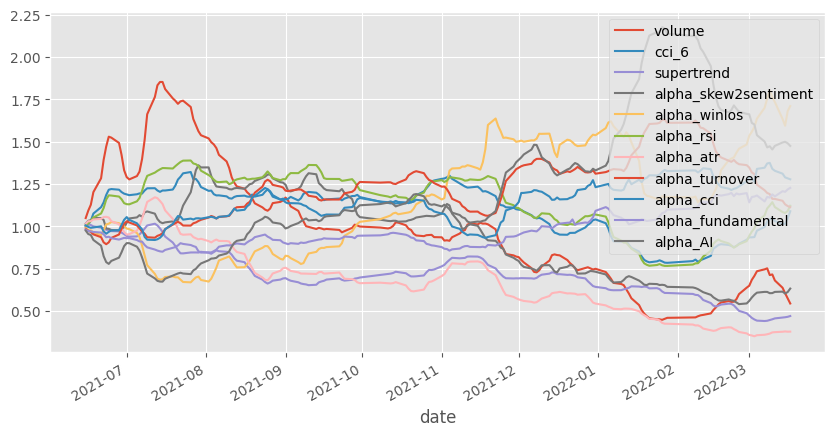

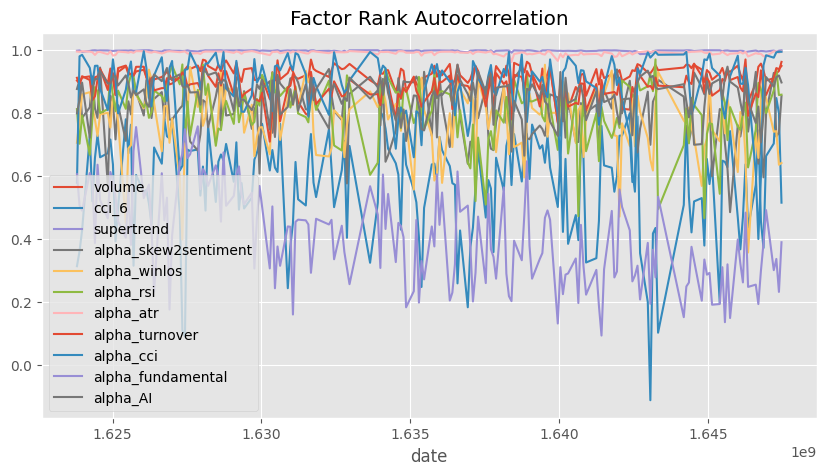

In [48]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [55]:
n_days = 2
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    'min_samples_split' : 1000,
    #'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 150

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [56]:
print(train_score)
print(valid_score, oob_score)

[0.40428225252269523]
[0.4172198958226943] [0.4013354700854701]


### View Train Set Results

Cleaning Data...

Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.0% in forward returns computation and 0.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

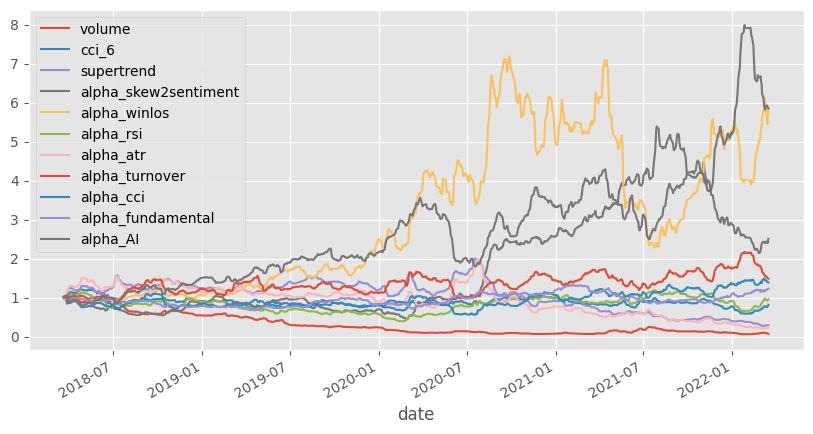

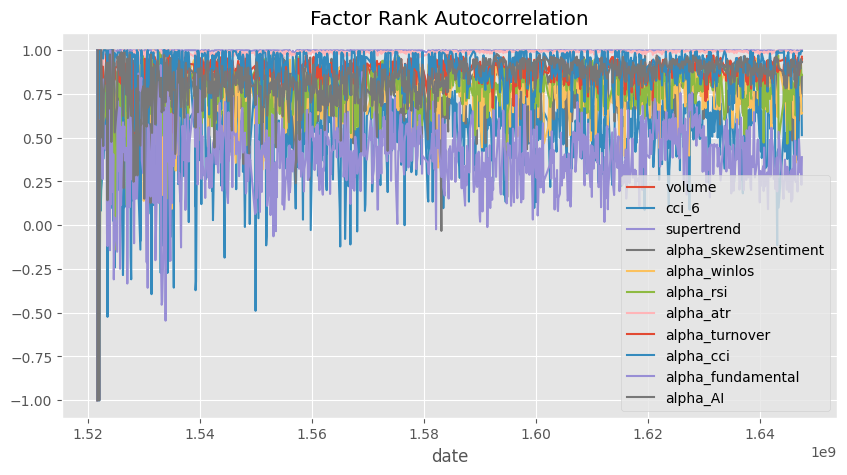

In [57]:
show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.2% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

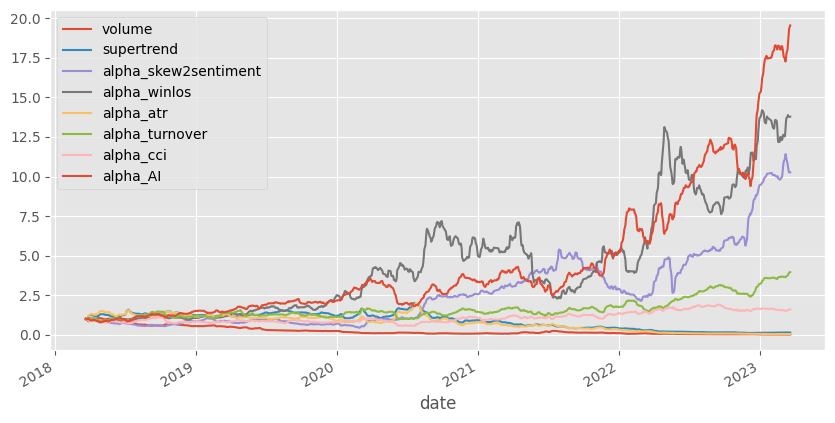

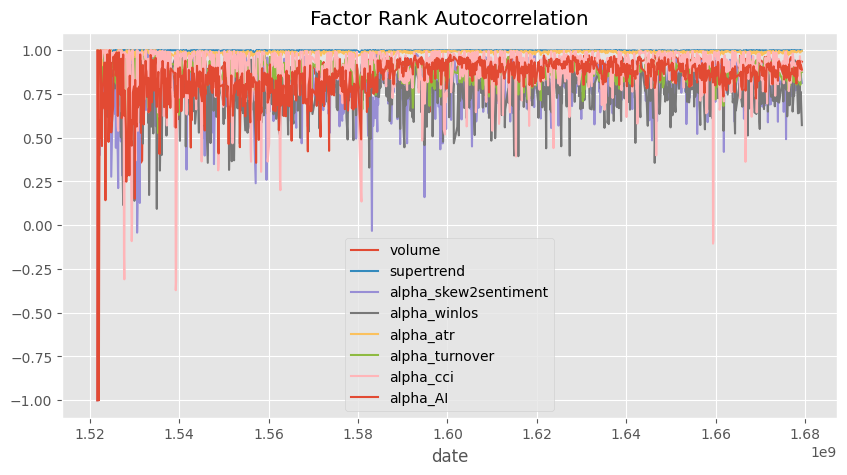

In [60]:
factor_names = [
                'volume', 'supertrend',
                'alpha_skew2sentiment', 'alpha_winlos', 
                'alpha_atr','alpha_turnover', 
                'alpha_cci', 
           ]
tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([tmp, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [62]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    return factors_with_alpha
    
all_factors = save_AI_factors(all_factors, clf_nov)
all_factors = all_factors.reset_index().set_index(['date'])
all_factors = universe.merge(all_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[0.05794306 0.05794306 0.04416913 ... 0.06636948 0.06434355 0.05056954] 53353


In [63]:
all_factors['alpha_volume'] = -all_factors['volume']
all_factors['alpha_supertrend'] = -all_factors['supertrend']
all_factors['alpha_atr'] = -all_factors['alpha_atr']

In [65]:
'''
 Sharpe Ratios
volume                 -2.13
supertrend             -1.68
alpha_skew2sentiment    1.74
alpha_winlos            1.74
alpha_atr              -2.15
alpha_turnover          1.35
alpha_cci               0.51
alpha_AI                2.48
dtype: float64
'''


field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret', 'return_2q', 
       'alpha_volume', 'alpha_atr', 'supertrend',
       'alpha_skew2sentiment','alpha_winlos','alpha_AI']

all_factors[field].to_csv('factors_AI_20170405_20230317.csv')

In [ ]:
tmp = all_factors[field]
#tmp = tmp.loc[tmp.industry=='化学制药']
tmp = tmp.loc[tmp['trade_date']>20220101]
tmp.to_csv('factor_tmp.csv')